In [ ]:
# Source: https://pytorch.org/tutorials/beginner/translation_transformer.html

In [ ]:
!pip install datasets
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install evaluate
!pip install transformers datasets evaluate sacrebleu
!pip install bert_score

  Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 977.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Transformer
import math
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from typing import Iterable, List
from tqdm.auto import tqdm
import datasets
import csv
from evaluate import load
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = datasets.load_dataset("wmt16", "de-en", split="train[:50000]")
val_data = datasets.load_dataset("wmt16", "de-en", split="validation")
test_data = datasets.load_dataset("wmt16", "de-en", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
token_transform = {}
vocab_transform = {}

token_transform["de"] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform["en"] = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    for data_sample in data_iter:
        yield token_transform[language](data_sample["translation"][language])


UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in ["de", "en"]:
    train_iter = iter(train_data)
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.

vocab_transform["de"].set_default_index(UNK_IDX)
vocab_transform["en"].set_default_index(UNK_IDX)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in ["de", "en"]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for xyz in batch:
        src_batch.append(text_transform["de"](xyz["translation"]["de"].rstrip("\n")))
        tgt_batch.append(text_transform["en"](xyz["translation"]["en"].rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
def load_model(model, optim, file_name):
    checkpoint = torch.load(file_name, map_location=torch.device(DEVICE))
    model.load_state_dict(checkpoint["model_state_dict"])
    optim.load_state_dict(checkpoint["optimizer_state_dict"])
    return checkpoint["epoch"]

In [ ]:
def plotloss(losses,name):
  epochs = range(1, len(losses) + 1)

  plt.plot(epochs, losses, marker='o', color='b', linestyle='-')


  plt.xlabel('Epoch Number')
  plt.ylabel(f'{name} Loss')
  plt.title(f'{name} Loss vs. Epoch Number')


  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
def train(model, epochs, loss_fxn, optimizer, data_loader_train):
    loss_per_ep = []
    for ep in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for X, y in data_loader_train:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_inp = y[:-1, :]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(X, y_inp)


            logits = model(X, y_inp, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

            y_out = y[1:, :]

            loss = loss_fxn(logits.reshape(-1, logits.shape[-1]), y_out.reshape(-1))
            train_loss += loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        lossperep = train_loss / len(list(data_loader_train))
        print("For Epoch "+str(ep)+" loss = "+str(lossperep))
        loss_per_ep.append(lossperep)

        torch.save({'epoch': ep,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()}, '/content/drive/MyDrive/Colab_data/NLP_AS3/models/model_Transformer_ep_'+str(ep)+'.pth')

def getValLoss(data_loader, model, opt, loss_fxn):
    val_loss_lst = []
    for i in range(37):
        fi_name = '/content/drive/MyDrive/Colab_data/NLP_AS3/models/model_Transformer_ep_'+str(i)+'.pth'
        load_model(model, opt, fi_name)
        model.eval()
        val_loss, n_val = 0, 0
        with torch.inference_mode():
            for X, y in data_loader:
                X, y = X.to(DEVICE), y.to(DEVICE)
                y_inp = y[:-1, :]
                src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(X, y_inp)

                logits = model(X, y_inp, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

                y_out = y[1:, :]

                val_loss += loss_fxn(logits.reshape(-1, logits.shape[-1]), y_out.reshape(-1))
                n_val += 1
        val_loss_lst.append(val_loss/n_val)
    return val_loss_lst

In [ ]:
torch.manual_seed(10)

SRC_VOCAB_SIZE = len(vocab_transform["de"])
TGT_VOCAB_SIZE = len(vocab_transform["en"])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=1, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=1, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
fi_name = '/content/drive/MyDrive/Colab_data/NLP_AS3/models/model_Transformer_ep_36.pth'
load_model(transformer, optimizer, fi_name)

19

In [ ]:
train(transformer, 20, loss_fn, optimizer, train_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

For Epoch 0 loss = 1.774635210909755
For Epoch 1 loss = 1.7045616393125904
For Epoch 2 loss = 1.6381227873642323
For Epoch 3 loss = 1.5756973335930573
For Epoch 4 loss = 1.5169352167551136
For Epoch 5 loss = 1.460804438293552
For Epoch 6 loss = 1.4073409382075128
For Epoch 7 loss = 1.3549650322529114
For Epoch 8 loss = 1.3045587393616684
For Epoch 9 loss = 1.2584447262001892
For Epoch 10 loss = 1.2135893148790164
For Epoch 11 loss = 1.170082652294247
For Epoch 12 loss = 1.1321407177092857
For Epoch 13 loss = 1.0943565918937068
For Epoch 14 loss = 1.0659900339688542
For Epoch 15 loss = 1.0409783989438932
For Epoch 16 loss = 1.0134313886011554
For Epoch 17 loss = 0.9871493353152687
For Epoch 18 loss = 0.9615751358269883
For Epoch 19 loss = 0.9359604748715519


In [ ]:
val_loss = getValLoss(val_dataloader, transformer, optimizer, loss_fn)
for i in range(len(val_loss)):
    val_loss[i] = float(val_loss[i])

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


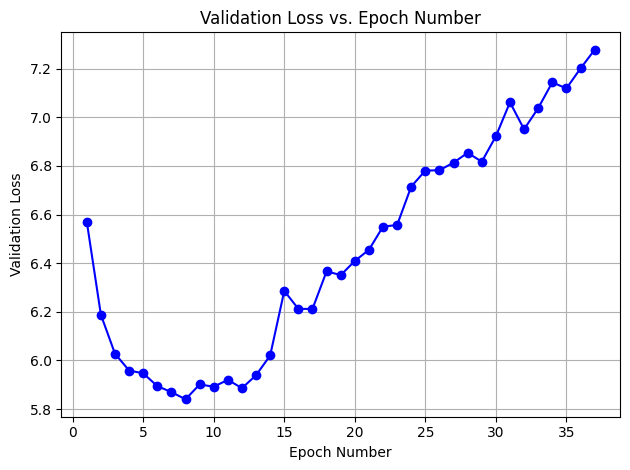

In [ ]:
plotloss(val_loss, "Validation")

In [ ]:
# Training loss obtained in different sessions of training.
train_loss = [
                5.473403709177321,
                4.59094432371973,
                4.137430163888083,
                3.7817305618574126,
                3.484854891829512,
                3.2318584561271693,
                3.020475917799078,
                2.835324836402693,
                2.6740002960100133,
                2.535769580879504,
                2.410565832144773,
                2.297004514982208,
                2.195984430139216,
                2.0990693864727814,
                2.00896257593017,
                1.9265951082177142,
                1.8488180806677996,
                1.774635210909755,
                1.7045616393125904,
                1.6381227873642323,
                1.5756973335930573,
                1.5169352167551136,
                1.460804438293552,
                1.4073409382075128,
                1.3549650322529114,
                1.3045587393616684,
                1.2584447262001892,
                1.2135893148790164,
                1.170082652294247,
                1.1321407177092857,
                1.0943565918937068,
                1.0659900339688542,
                1.0409783989438932,
                1.0134313886011554,
                0.9871493353152687,
                0.9615751358269883,
                0.9359604748715519,
            ]

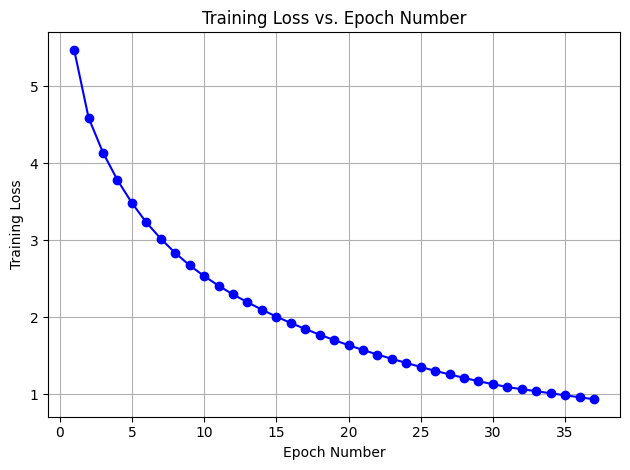

In [ ]:
plotloss(train_loss, "Training")

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform["de"](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform["en"].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people is meeting of human beings . 


In [ ]:
# Test
german_test = []
english_test = []
for samples in test_data["translation"]:
    german_test.append(samples["de"])
    english_test.append(samples["en"].split(" "))

In [ ]:
translated_text = []
for sent in german_test:
    translated_text.append(translate(transformer, sent))

In [ ]:
with open("/content/translated_sent.txt", "w") as f:
    for items in translated_text:
        f.write('%s\n' %items)

In [ ]:
translated_text1 = []
for x in translated_text:
    translated_text1.append(x.split(" "))

In [ ]:
def infe_from_csv(file_loc):
    with open(file_loc, mode="r") as f:
        ger_sent = list(csv.reader(f))
    ger_sent = ger_sent[1:]
    rows = []
    for sent in ger_sent:
        temp = []
        temp.append(sent[0])
        temp.append(translate(transformer, sent[0]))
        rows.append(temp)
    with open("/content/out.csv", 'w') as f:
        csvwriter = csv.writer(f)
        csvwriter.writerow(["de", "en"])
        csvwriter.writerows(rows)


In [ ]:
translated_sen_loc = "/content/drive/MyDrive/Colab_data/NLP_AS3/translated_sent.txt"
with open(translated_sen_loc, 'r') as f:
    translated_sentences = f.readlines()

In [ ]:
print(translated_sentences)

[' For the years \n', ' The relationship between the protracted and effect of the protracted and not just structural funds is an\n', ' The two countries wanted to follow the implementation of the international agreement and about EUR 885.5 million , as well as job creation in the\n', ' But we also need to see the found conflict with the - as - as the Böge , and I could start over the period\n', ' The relationship between the protracted and effect of the protracted and action plan has been even been\n', " Washington ' s continuing to die of the protracted and yet fresh will rise to a protracted and raises kind of\n", ' The effect of the protracted increase in the period of protracted only has been about the When express my endeavours of two - way into\n', ' In March , the protracted discussion of the only air effect was an controversial reference which was , in fact , many of which was seen as an affront . \n', ' The meeting of the now was not followed with a met meeting of the Treaty ,

In [ ]:
references = []
predictions = []
for i in range(len(test_data)):
  references.append(test_data[i]["translation"]["en"])
predictions = translated_sentences

from evaluate import load
bertT = load("bertscore")
meteorT = load('meteor')
bleuT = load("bleu", max_order=1)
bleuT2 = load("bleu", max_order=2)
bleuT3 = load("bleu", max_order=3)
bleuT4 = load("bleu", max_order=4)

#bertR = bertT.compute(predictions=predictions, references=references, lang="de")
meteorR = meteorT.compute(predictions=predictions, references=references)
bleuR = bleuT.compute(predictions=predictions, references=references, max_order=1)
bleuR2 = bleuT2.compute(predictions=predictions, references=references, max_order=2)
bleuR3 = bleuT3.compute(predictions=predictions, references=references, max_order=3)
bleuR4 = bleuT4.compute(predictions=predictions, references=references, max_order=4)

#print("BertScore is: ", bertR)
print("Meteor Score is: ", meteorR)
print("Bleu-1 Score is: ", bleuR)
print("Bleu-2 Score is: ", bleuR2)
print("Bleu-3 Score is: ", bleuR3)
print("Bleu-4 Score is: ", bleuR4)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Meteor Score is:  {'meteor': 0.22941659673628328}
Bleu-1 Score is:  {'bleu': 0.2574172392254841, 'precisions': [0.2574172392254841], 'brevity_penalty': 1.0, 'length_ratio': 1.1985214990876338, 'translation_length': 76848, 'reference_length': 64119}
Bleu-2 Score is:  {'bleu': 0.1306106188497208, 'precisions': [0.2574172392254841, 0.06627036249644545], 'brevity_penalty': 1.0, 'length_ratio': 1.1985214990876338, 'translation_length': 76848, 'reference_length': 64119}
Bleu-3 Score is:  {'bleu': 0.07239764582103247, 'precisions': [0.2574172392254841, 0.06627036249644545, 0.022244177840508115], 'brevity_penalty': 1.0, 'length_ratio': 1.1985214990876338, 'translation_length': 76848, 'reference_length': 64119}
Bleu-4 Score is:  {'bleu': 0.04232843806620156, 'precisions': [0.2574172392254841, 0.06627036249644545, 0.022244177840508115, 0.008459713195089239], 'brevity_penalty': 1.0, 'length_ratio': 1.1985214990876338, 'translation_length': 76848, 'reference_length': 64119}
